# Geospatial data notebook

This is an analysis of some remaining questions that are more easily visualized on a map. We start here with the smaller dataset of December 2022.

Questions analyzed here:

- Usage of stations as distributed geospatially
- Surplus/deficits at stations, also visualized geospatially via an interactive map

In [1]:
import os
import pandas as pd
from datetime import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h3pandas
from keplergl import KeplerGl
import folium
import json

from IPython.display import Image

## Import data

In [2]:
# Divvy bike ride data
df = pd.read_csv('tmp/202212-divvy-tripdata.csv')
df = df.convert_dtypes()
df['started_at'] = pd.to_datetime(df['started_at'], format='%Y-%m-%d %H:%M:%S')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='%Y-%m-%d %H:%M:%S')

# Station data
station_df = pd.read_csv('data/station_df.csv', index_col=0).rename(columns={'lon': 'lng'})
station_df = station_df[['name', 'lat', 'lng', 'station_type', 'capacity']]  # only need a few of these

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181806 entries, 0 to 181805
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             181806 non-null  string        
 1   rideable_type       181806 non-null  string        
 2   started_at          181806 non-null  datetime64[ns]
 3   ended_at            181806 non-null  datetime64[ns]
 4   start_station_name  152523 non-null  string        
 5   start_station_id    152523 non-null  string        
 6   end_station_name    150648 non-null  string        
 7   end_station_id      150648 non-null  string        
 8   start_lat           181806 non-null  Float64       
 9   start_lng           181806 non-null  Float64       
 10  end_lat             181678 non-null  Float64       
 11  end_lng             181678 non-null  Float64       
 12  member_casual       181806 non-null  string        
dtypes: Float64(4), datetime64[ns]

In [4]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1420
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1421 non-null   object 
 1   lat           1421 non-null   float64
 2   lng           1421 non-null   float64
 3   station_type  1421 non-null   object 
 4   capacity      1421 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 66.6+ KB


## Preliminary visuals

First visualize how stations are distributed. H3 provides us with a useful way to tile the map and bin results. It minimizes distortion vs. rectangular tiling patterns, and it provides equidistant nearest neighbors.

It efficiently couples with pandas/Geopandas, so it works well with maps.

In [6]:
stat_distr = station_df[['name', 'lat', 'lng']].h3.geo_to_h3(8).drop(columns=['lat', 'lng'])
stat_distr = stat_distr.groupby('h3_08').count().h3.h3_to_geo_boundary()

stat_distr.rename(columns={'name': 'station count'}).explore(column='station count', cmap='Wistia')

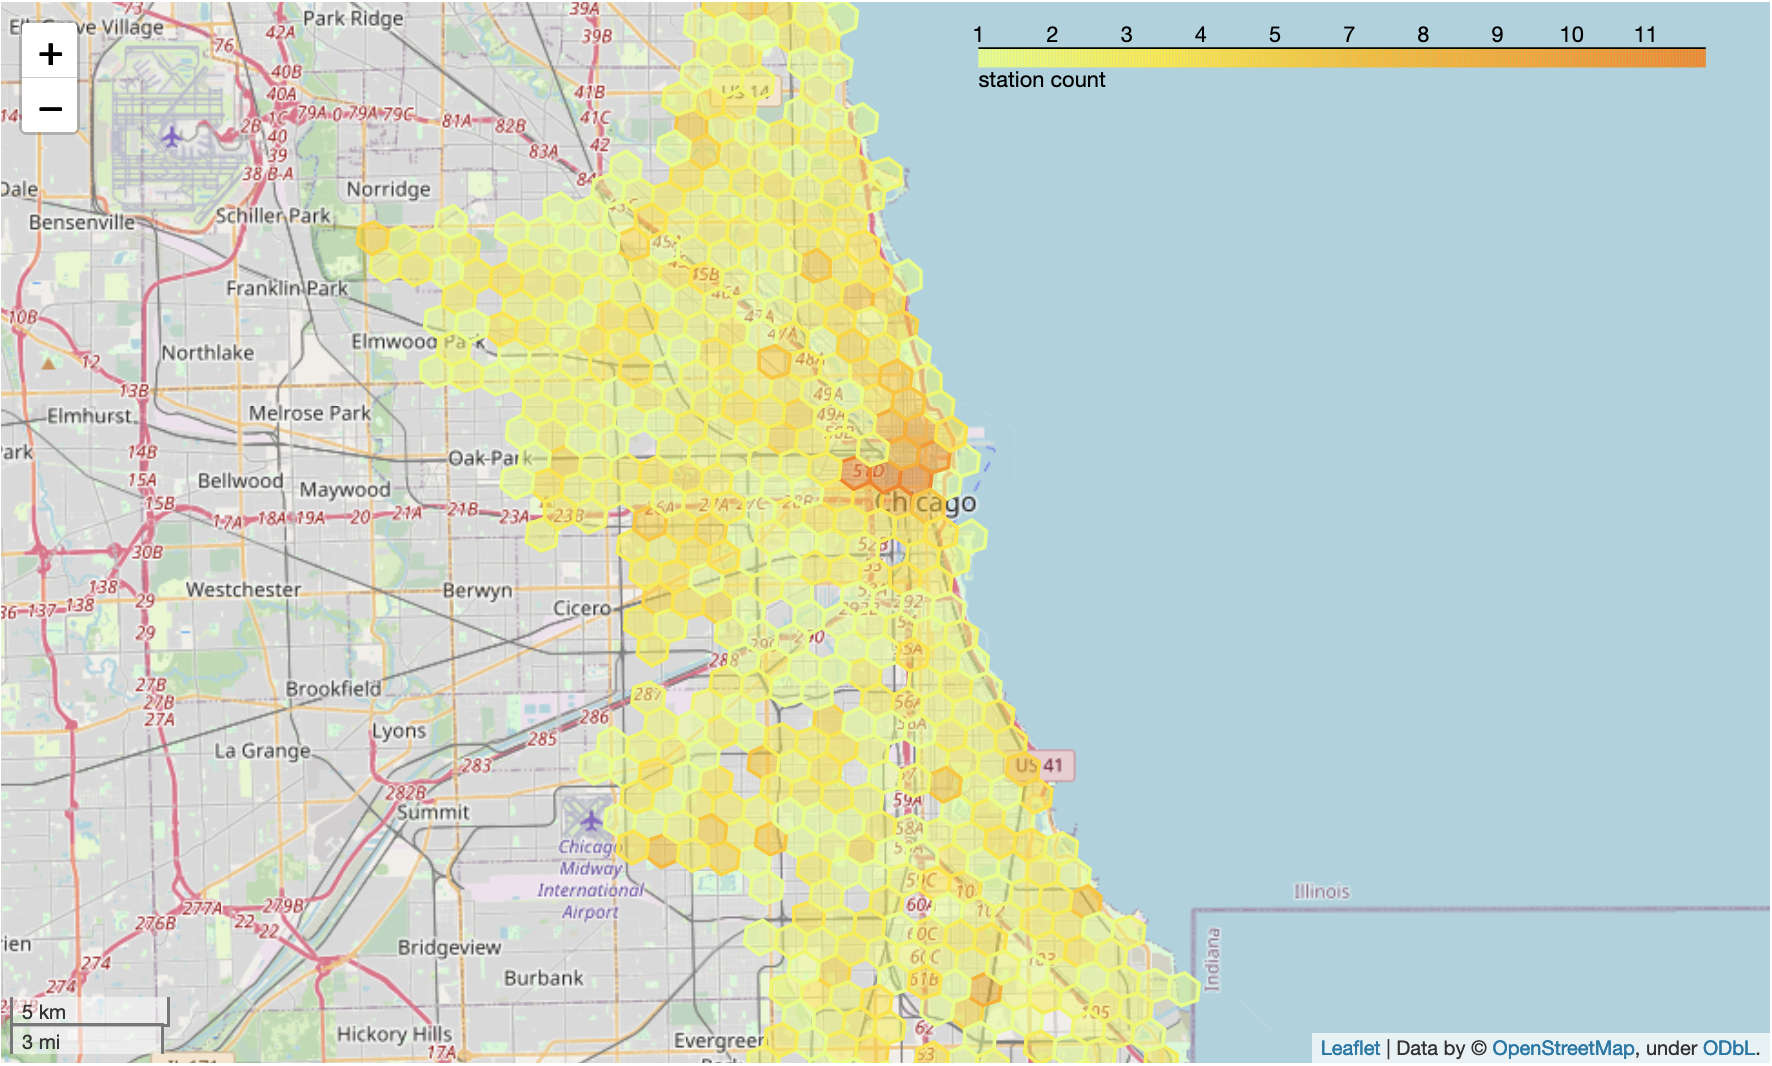

In [5]:
Image('Figures/Folium_station_distr.png')

The hexagons mostly have 1 station per tile, but there are more concentrated near the Navy Pier and Millenium Park.

Let's look at the concentration of usage next, which we define here as amount of transactions (both starting and ending rides) in the month of December

In [6]:
# need to ignore nans
df_activity_start = df.loc[df.start_station_id.notnull(), ['start_lat', 'start_lng', 'start_station_id']]\
                    .h3.geo_to_h3(8, lat_col='start_lat', lng_col='start_lng', set_index=False)\
                    .drop(columns=['start_lat', 'start_lng'])

df_activity_end = df.loc[df.end_station_id.notnull(), ['end_lat', 'end_lng', 'end_station_id']]\
                    .h3.geo_to_h3(8, lat_col='end_lat', lng_col='end_lng', set_index=False)\
                    .drop(columns=['end_lat', 'end_lng'])

df_activity_start = df_activity_start.groupby('h3_08').count().rename(columns={'start_station_id': 'cnt'})
df_activity_end = df_activity_end.groupby('h3_08').count().rename(columns={'end_station_id': 'cnt'})

total_activity = pd.concat((df_activity_start, df_activity_end), axis=0).groupby('h3_08').sum('cnt')\
            .h3.h3_to_geo_boundary()

total_activity['log10(transaction count)'] = np.log10(total_activity['cnt'])
total_activity.rename(columns={'cnt': 'transaction count'}, inplace=True)

total_activity.explore(column='transaction count', cmap='RdPu',
                       tooltip=['log10(transaction count)', 'transaction count'],
                       popup=['log10(transaction count)', 'transaction count'])

# Could also plot the log10(transaction count)

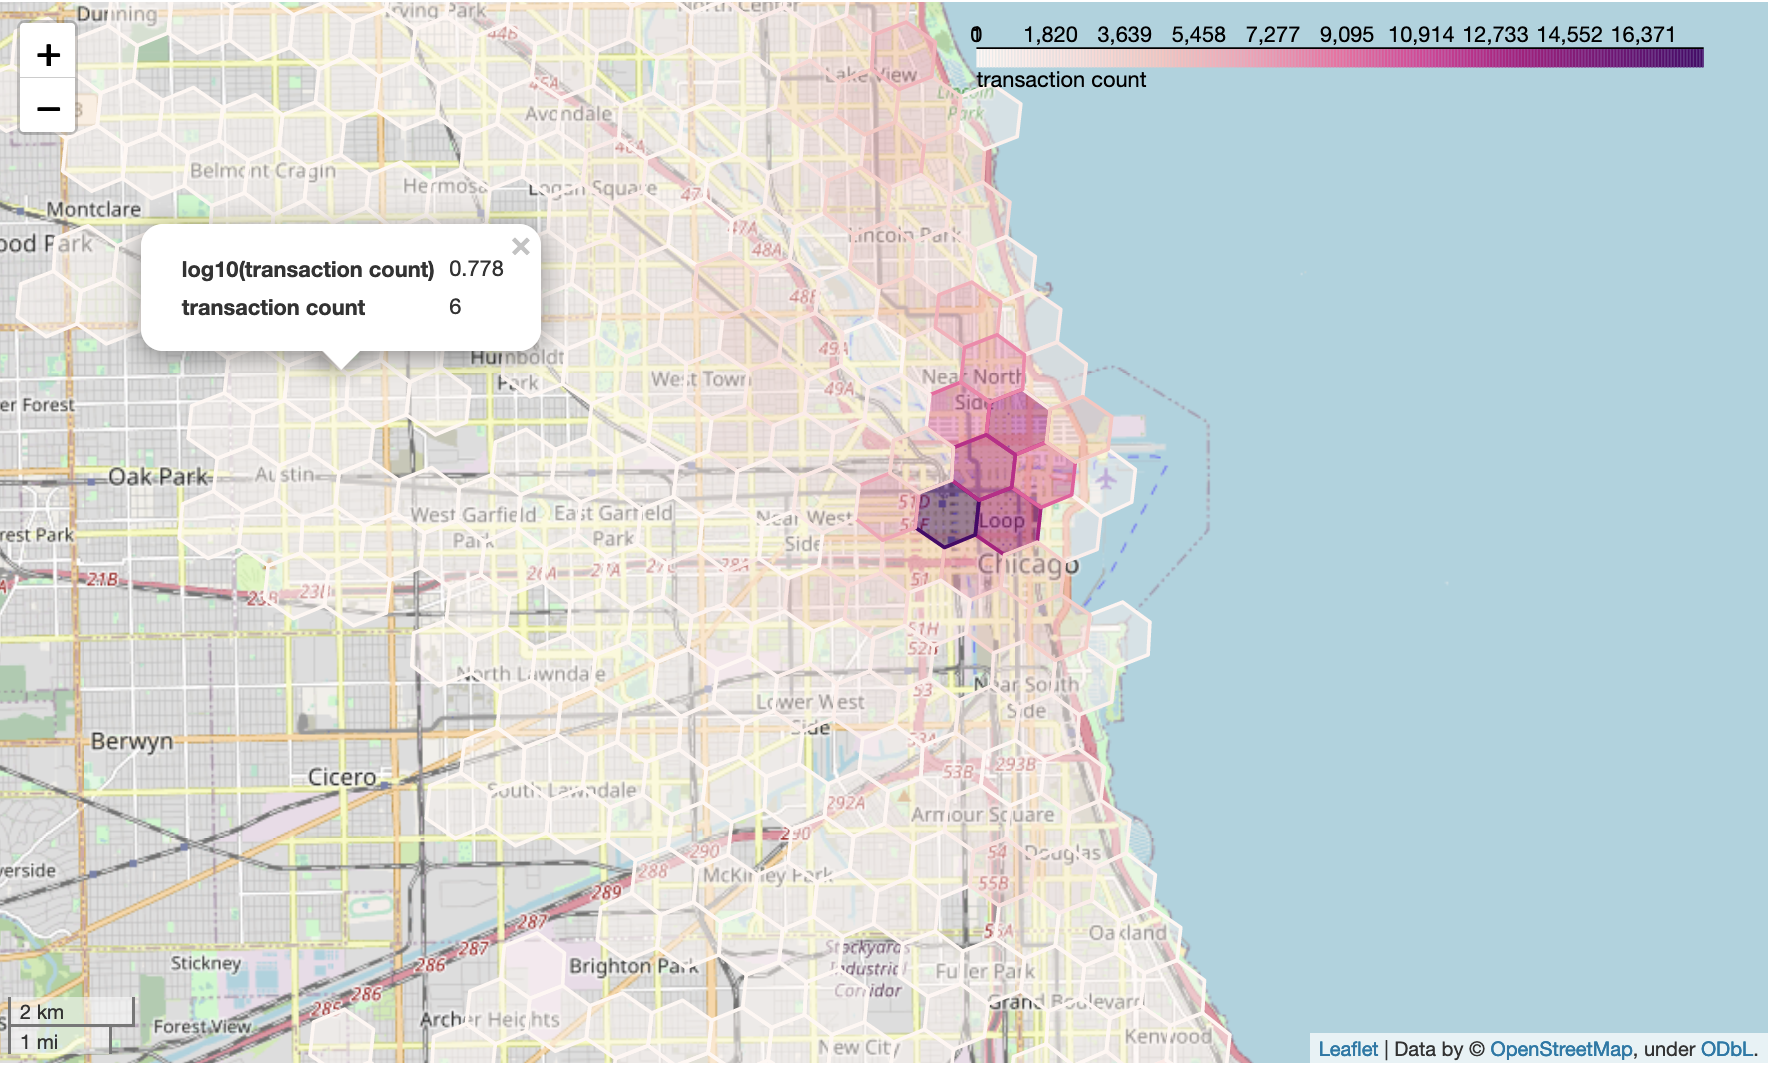

In [7]:
Image('Figures/Folium_transactions.png')

Another way of visualizing

In [7]:
with open('map1_config.json') as file:
    m1_config = json.load(file)
    
map_1 = KeplerGl(data={'transaction counts': total_activity}, config=m1_config)
#map_1

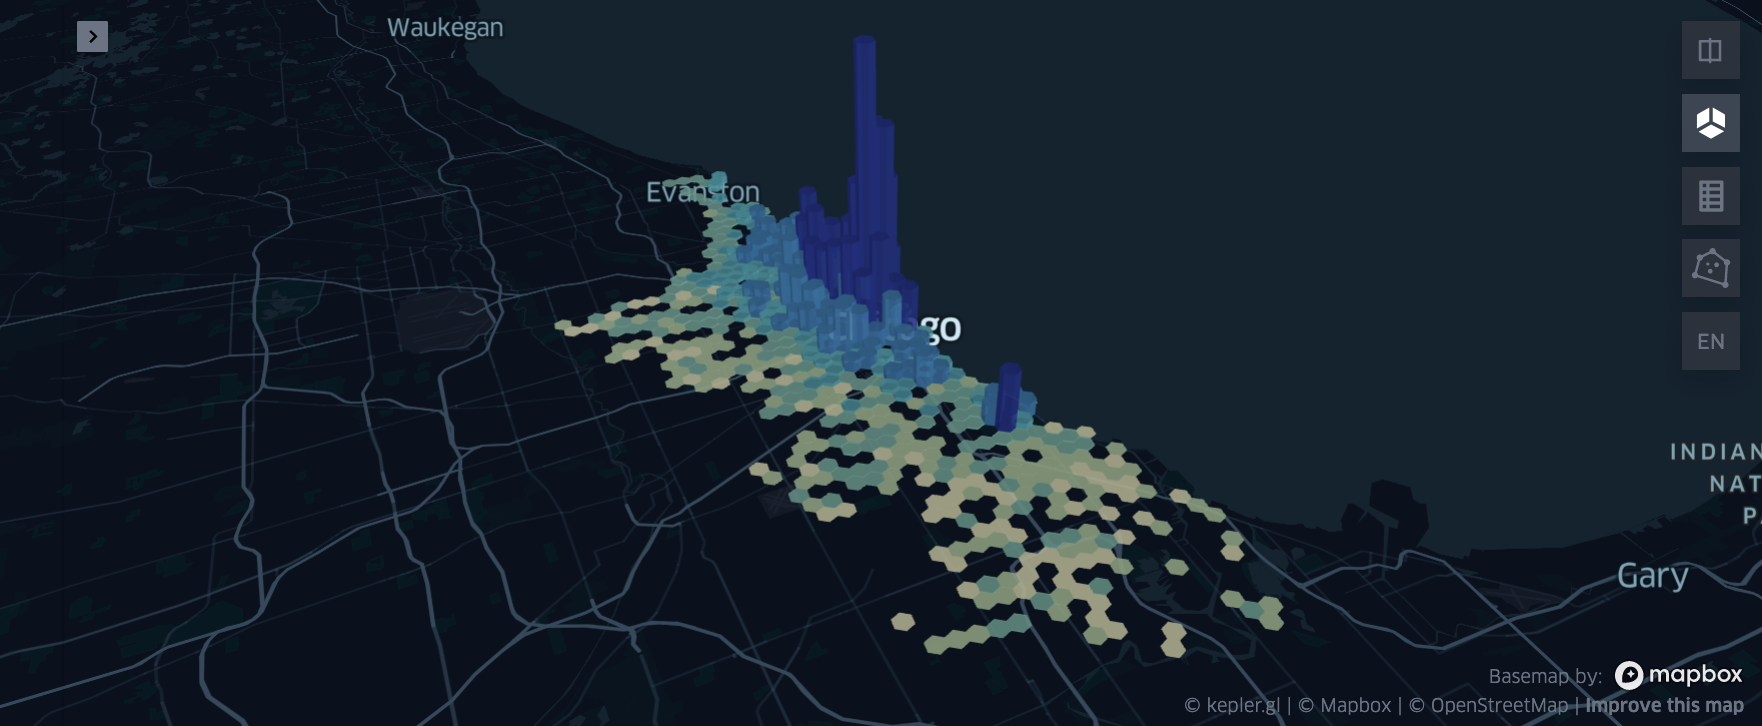

In [8]:
Image('Figures/KeplerUsage.png')

Here the color represents the logarithmic usage counts, and the heights are the linear usage counts.

Note that we use the polygon geometry here rather than the H3 indexes since the Jupyter notebook has issues with H3 indexing, although we could go straight from index to map in an interactive .html file.

In [8]:
# # To save the configuration we made on the UI
# m1_config = map_1.config

# with open('map1_config.json', 'w+') as file:
#     json.dump(m1_config, file)

The usage is also highly concentrated near the Navy Pier and Millenium park as expected.

## Bike surplus/deficits

For this next part, we want to see how many bikes each region or station is maintaining, and whether there are common surpluses or deficits at certain parts of the month. Since we do not have the number of bikes each station started with, we will assume it starts with the median value (over all time intervals). If we are given the data of how many bikes are at each station at any point in time, we can backtrace and get the actual values. We will form a column for each station called "surplus", which is 0 when at the median, positive when there's a surplus, and negative when there's a deficit.

A few points to note:

- We will focus on the top 500 stations (about half) in terms of usage since less-used stations will not undergo as large fluctuations anyway.
- We will ignore the start point when there is no associated start station id, and same for end points.
- We will assume, for efficiency, that the problems from people parking classic bikes at lightweight stations is negligible, since the vast majority of people will use the stations correctly.

### Attempt at H3 geometry to define stations

Let us try this time, instead of focusing on names, which can have issues, we will look for h3 hexes, which will be easy to group and avoid name anomalies. Plus, there is not a huge problem for users if they just have to cross the street to park their bike at a rack or pick a bike up.

First, we need to find the resolution where stations do not obviously overlap each other. There are a couple that seemingly go by a few different names (perhaps old versions of the stations?), there are several where there's a name including "Public Rack" and one without it, and a few where it looks like it's on opposite sides of an intersection.

In [9]:
stat_h3 = station_df.drop(columns=['station_type', 'capacity']).h3.geo_to_h3(11).drop(columns=['lat', 'lng'])

In [10]:
h3_counts = stat_h3.groupby('h3_11').count()
two_stat = h3_counts[h3_counts.name > 1]
two_stat

name
h3_11                
8b266452c926fff     2
8b2664c104acfff     2
8b2664c1ec00fff     2
8b2664c81909fff     2
8b2664c8926afff     2
8b2664c8c35dfff     2
8b2664ca3d9cfff     2
8b2664caeaf4fff     2
8b2664cb2c63fff     2
8b2664cc461afff     2
8b2664cc53aafff     2
8b2664cc8999fff     2
8b2664cd5919fff     2
8b2664cd902cfff     2

In [11]:
stat_h3.loc[two_stat.index]

name
h3_11                                                             
8b266452c926fff                                Tripp Ave & 65th St
8b266452c926fff                       Public Rack - West Lawn Park
8b2664c104acfff                         Wilton Ave & Diversey Pkwy
8b2664c104acfff                        Wilton Ave & Diversey Pkwy*
8b2664c1ec00fff                                  Clark St & Elm St
8b2664c1ec00fff                              N Clark St & W Elm St
8b2664c81909fff                              Kostner Ave & Lake St
8b2664c81909fff                Public Rack - Kostner Ave & Lake St
8b2664c8926afff                               Archer Ave & 43rd St
8b2664c8926afff  Public Rack - Brighton Park Branch Chicago Lib...
8b2664c8c35dfff                       Central Park Ave & Ogden Ave
8b2664c8c35dfff         Public Rack - Central Park Ave & Ogden Ave
8b2664ca3d9cfff                       Kostner Ave & Wrightwood Ave
8b2664ca3d9cfff         Public Rack - Kostner Ave & Wrightwood Ave
8b2664caeaf4fff                         California Ave & Cortez St
8b2664caeaf4fff           Public Rack - California Ave & Cortez St
8b2664cb2c63fff                              Panama Ave & Grace St
8b2664cb2c63fff              Public Rack - Canty Elementary School
8b2664cc461afff                        Prairie Ave & Garfield Blvd
8b2664cc461afff        Public Rack - Prairie Ave & Garfield Blvd N
8b2664cc53aafff                         Stony Island Ave & 63rd St
8b2664cc53aafff                              Cornell Dr & Hayes Dr
8b2664cc8999fff                             East End Ave & 87th St
8b2664cc8999fff                Public Rack - Cornell Ave & 87th Pl
8b2664cd5919fff                  Public Rack - Laflin St & 51st St
8b2664cd5919fff                   Public Rack - Laflin St &51st ST
8b2664cd902cfff            Public Rack - Halsted St & 95th St - SW
8b2664cd902cfff            Public Rack - Halsted St & 95th St - SE

Any higher resolution, and we will probably miss points due to gps drift. Any lower resolution, and the stations will blend together.

Plot these stations and the points where bikes start from df

In [12]:
h3_stations = stat_h3.groupby('h3_11').first()

m = h3_stations.h3.h3_to_geo_boundary().explore(tooltip='name', popup='name', name='Stations')

# Also plot the 
station_starts = df.loc[df.start_station_id.notnull(), ['start_lng', 'start_lat']]\
                        .h3.geo_to_h3(11, lat_col='start_lat', lng_col='start_lng')
station_starts = station_starts.groupby('h3_11').count()\
                        .drop(columns='start_lat').rename(columns={'start_lng': 'cnt'})
station_starts.h3.h3_to_geo_boundary().explore(m=m, column='cnt', cmap='RdPu', name='Ride Counts')
folium.LayerControl().add_to(m)
#m

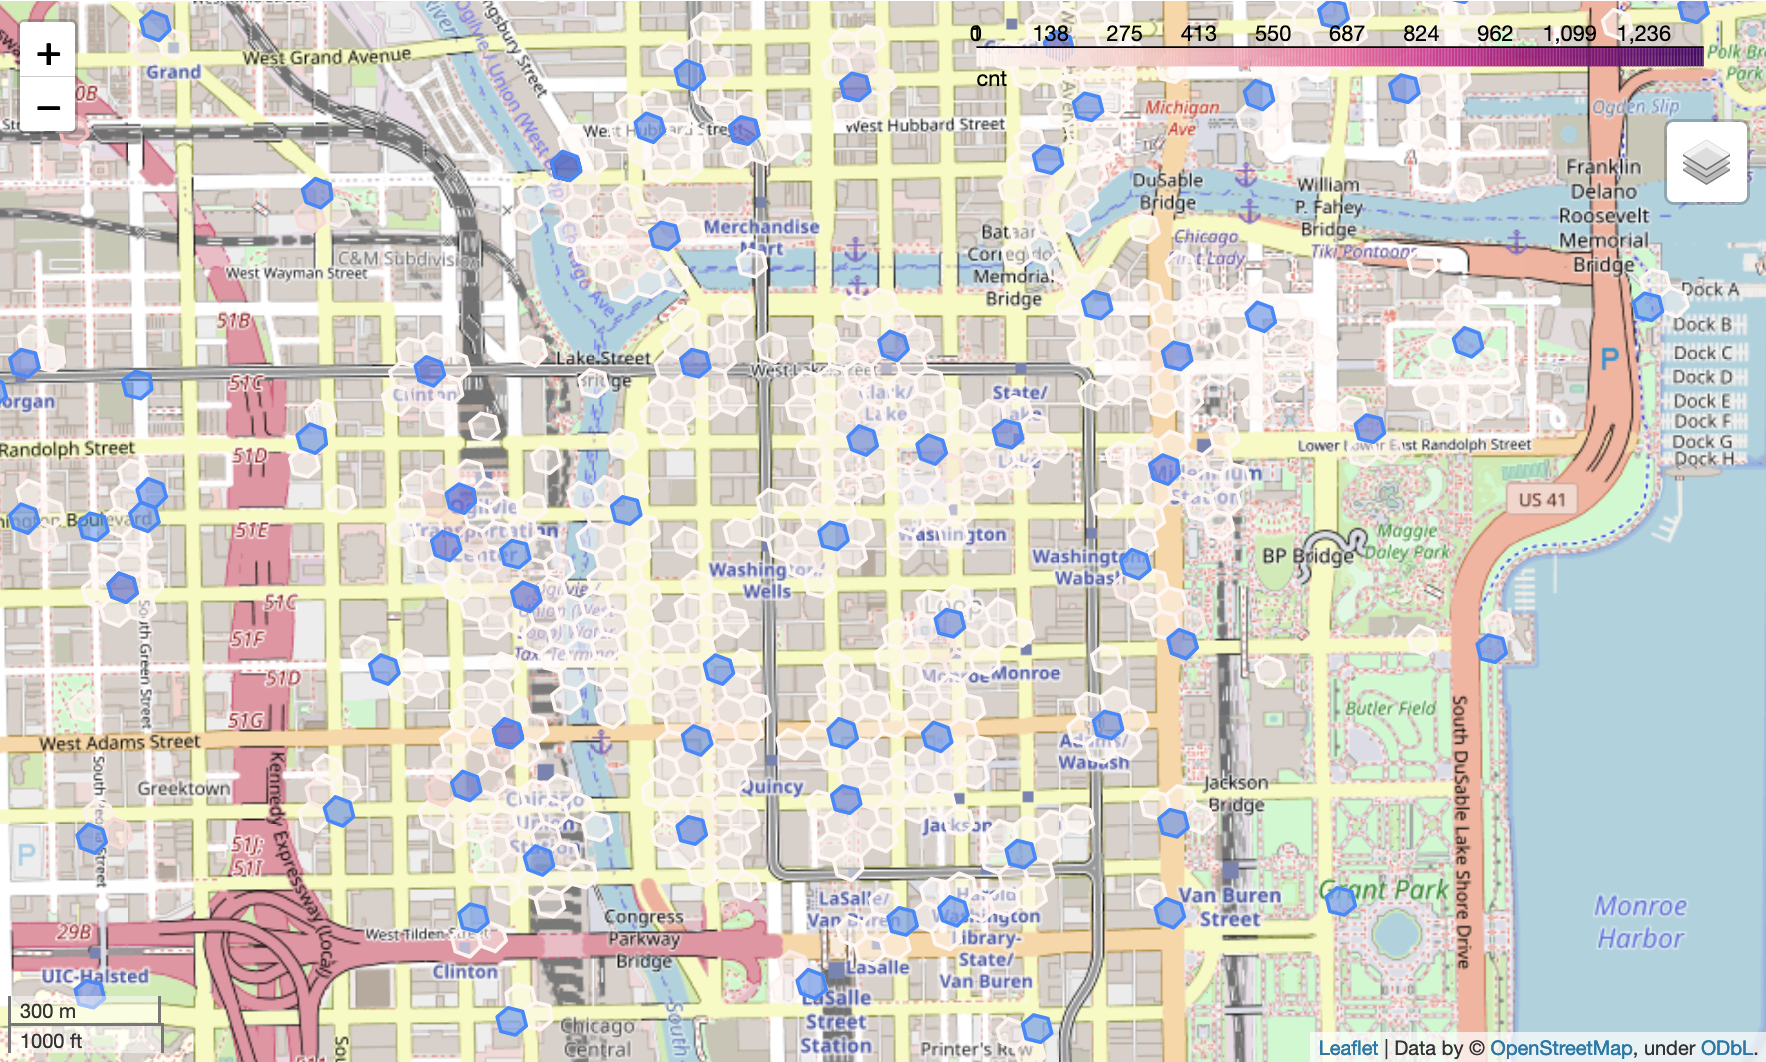

In [12]:
Image('Figures/FoliumStationGPS.png')

We see that the locations of stations vary far more for the bike ride data. This is likely due to inaccurate GPS devices on the bikes, and it can't be fixed by just decreasing the resolution or including nearest neighbors.

### Surplus/deficits by connecting names to H3 indices and then sorting/aggregating

Use a similar procedure as in the Revenue/Types analysis. Join the station_df to the original df based on names.

In [13]:
stat_h3 = stat_h3.reset_index().set_index('name')

df_start = df.loc[df.start_station_id.notnull(), ['started_at', 'start_station_name']]\
                    .rename(columns={'started_at': 'timestamp', 'start_station_name': 'name'})

df_end = df.loc[df.end_station_id.notnull(), ['ended_at', 'end_station_name']]\
                    .rename(columns={'ended_at': 'timestamp', 'end_station_name': 'name'})

# replace the names that actually are in station_df and merge
df_start.loc[df_start.name == 'Loomis St & Lexington St*', 'name'] = 'Loomis St & Lexington St'
df_start.loc[df_start.name == 'Campbell Ave & Montrose Ave (Temp)', 'name'] = 'Campbell Ave & Montrose Ave'
df_start.loc[df_start.name == 'Racine Ave & Fullerton Ave (Temp)', 'name'] = 'Racine Ave & Fullerton Ave'
df_start = df_start.merge(stat_h3, how='inner', left_on='name', right_index=True)

# same for end stations
df_end.loc[df_end.name == 'Loomis St & Lexington St*', 'name'] = 'Loomis St & Lexington St'
df_end.loc[df_end.name == 'Campbell Ave & Montrose Ave (Temp)', 'name'] = 'Campbell Ave & Montrose Ave'
df_end.loc[df_end.name == 'Racine Ave & Fullerton Ave (Temp)', 'name'] = 'Racine Ave & Fullerton Ave'
df_end = df_end.merge(stat_h3, how='inner', left_on='name', right_index=True)

display(df_start.info())
display(df_end.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152271 entries, 0 to 178626
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  152271 non-null  datetime64[ns]
 1   name       152271 non-null  object        
 2   h3_11      152271 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150381 entries, 0 to 181244
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  150381 non-null  datetime64[ns]
 1   name       150381 non-null  object        
 2   h3_11      150381 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.6+ MB


None

No null objects. First sort to find the top 500 stations by transaction count (usage) for the month

In [14]:
df_usage = pd.concat((df_start, df_end), axis=0)
top_usage = df_usage[['h3_11', 'name']].groupby('h3_11').count()\
                                                .sort_values('name', ascending=False).head(500)

display(top_usage.head(6))
display(top_usage.tail(6))

df_start = df_start[df_start.h3_11.isin(top_usage.index)]

df_end = df_end[df_end.h3_11.isin(top_usage.index)]

print(df_start.shape, df_end.shape)

name
h3_11                
8b2664c1e6b2fff  2844
8b2664c1ac32fff  2732
8b2664c1ec00fff  2413
8b2664c1e188fff  2359
8b2664c1ac10fff  2211
8b2664c1aceafff  2166

name
h3_11                
8b2664d8a4aefff    61
8b2664d81734fff    61
8b2664cf64c5fff    61
8b2664cb3819fff    61
8b2664cb0c85fff    61
8b2664d8128cfff    60

(148339, 3) (146863, 3)


In [15]:
# Attach a number to each transaction: 1 for end stations (since bikes increase there)
# and -1 for start stations (since bikes leave there)

df_start['surplus'] = -np.ones(df_start.shape[0], dtype=int)
df_end['surplus'] = np.ones(df_end.shape[0], dtype=int)

In [16]:
df_surplus = pd.concat((df_start.drop(columns='name'), df_end.drop(columns='name')), axis=0)

df_surplus.sort_values(['h3_11', 'timestamp'], inplace=True)

df_surplus = df_surplus.set_index(['h3_11', 'timestamp'])

display(df_surplus.shape)

df_surplus.head(10)

(295202, 1)

surplus
h3_11           timestamp                   
8b2664c10003fff 2022-12-01 00:48:51        1
                2022-12-01 05:40:32       -1
                2022-12-01 06:07:56       -1
                2022-12-01 06:42:28       -1
                2022-12-01 06:49:07       -1
                2022-12-01 06:59:15       -1
                2022-12-01 07:47:43       -1
                2022-12-01 09:14:38        1
                2022-12-01 10:08:01       -1
                2022-12-01 10:09:03        1

We now have an array of transaction timestamps at the top 500 stations (represented by H3 indices).

We want to do a window function on the h3 index, resample the timestamp in intervals of 1 hour (summing values between there), and doing a cumsum aggregation on the surplus index (within each h3 index).

In [17]:
df_surplus_resample = df_surplus.groupby('h3_11').resample('1H', level=1, group_keys=True).aggregate('sum')

df_surplus_final = df_surplus_resample.groupby('h3_11').cumsum()

# Subtract out the mean. This is how we can do an SQL-like window function keeping the rows
# round to nearest since having half a bike surplus doesn't make sense
df_surplus_final -= df_surplus_final.groupby('h3_11').transform(lambda x: round(x.median()))

Note that above is where we can insert the actual values of bike surplus (and not our estimate based on the median) given the number in each station at a given time point.

We can find which stations had the greatest and least surplus:

In [20]:
df_surplus_final.groupby('h3_11').max('surplus').sort_values('surplus', ascending=False).head(10)

surplus
h3_11                   
8b2664c1ecd2fff      126
8b2664c1e6aafff      126
8b2664c1aa19fff      112
8b2664c1e463fff      103
8b2664c1e4e6fff       91
8b2664c1e258fff       87
8b2664c1bd55fff       78
8b2664cf58c0fff       77
8b2664c1a48cfff       69
8b2664c1a02dfff       62

And the greatest and least deficits:

In [21]:
df_surplus_final.groupby('h3_11').min('surplus').sort_values('surplus', ascending=True).head(10)

surplus
h3_11                   
8b2664c1e258fff     -103
8b2664c1e463fff      -80
8b2664c1bd55fff      -78
8b2664c1ac32fff      -69
8b2664c1aa19fff      -63
8b2664c1e066fff      -63
8b2664c16b01fff      -63
8b2664cad31efff      -60
8b2664cada0afff      -59
8b2664c1a94afff      -57

## Visualize the surplus

For visualization on Jupyter Notebook, we will use the geometry

In [20]:
df_surplus_f = df_surplus_final.reset_index('timestamp').h3.h3_to_geo_boundary()

df_surplus_f.sort_values('timestamp', inplace=True)

In [21]:
with open('map2_config.json') as f:
    map2_config = json.load(f)

map_2 = KeplerGl(data={'surplus': df_surplus_f}, config=map2_config)
#map_2
## screenshot in the readme

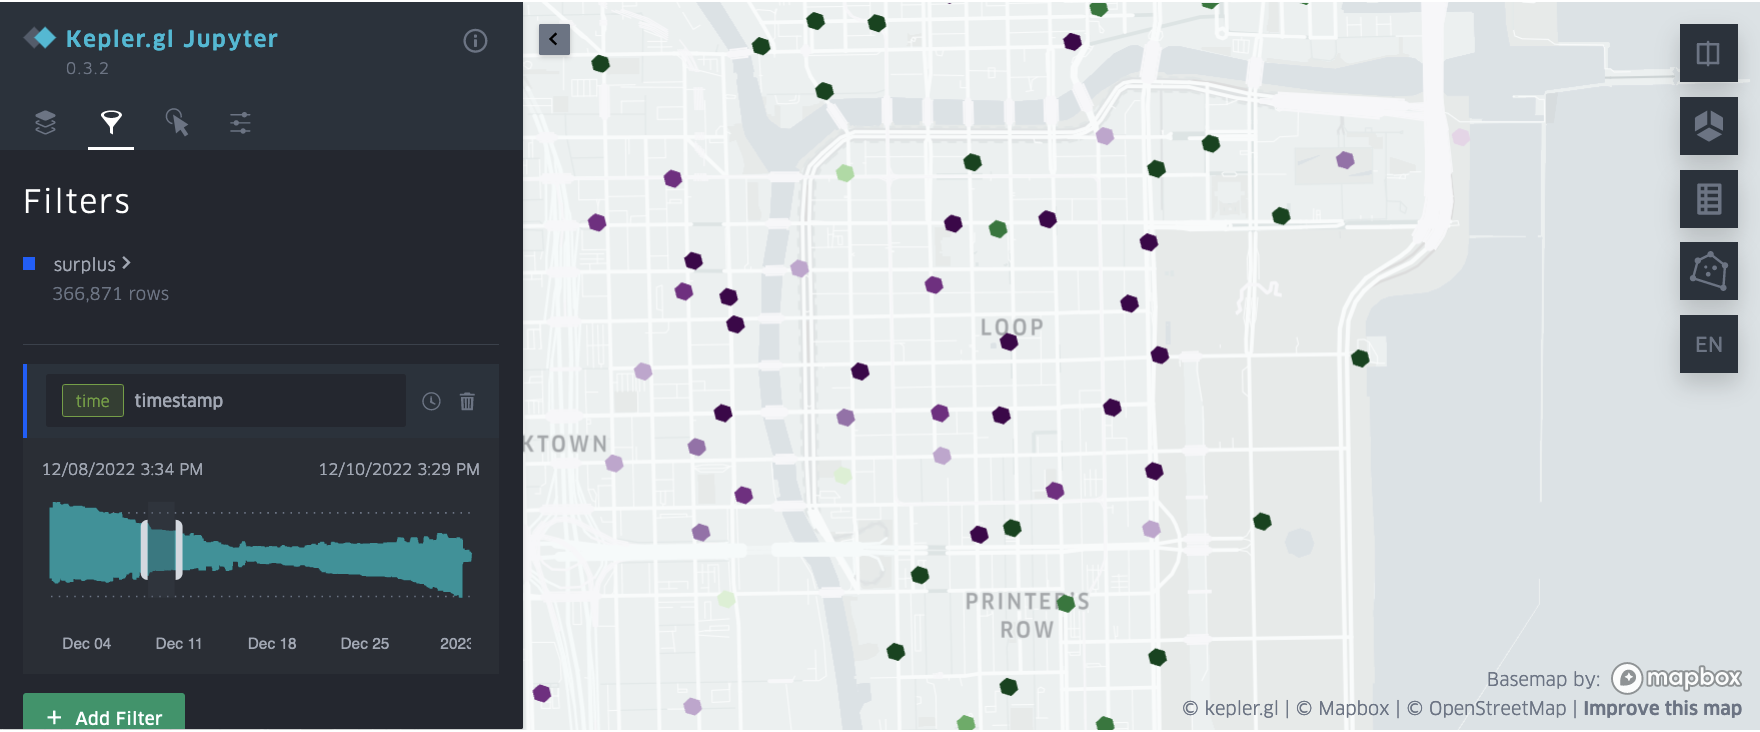

In [22]:
Image('Figures/KeplerRideSurplus.png')

In [226]:
# # write to a config file
# with open('map2_config.json', 'w+') as f:
#     json.dump(map_2.config, f)

Here Kepler is showing a picture of surplus values for a time range between December 8 at 3:34pm till December 10 at 3:29 pm.

Green values are when the station surpluses are positive, and purple values are negative. Light values are in between.

Check that it's doing something reasonable

In [22]:
stat_h3[stat_h3.index == 'Millennium Park']  # this one is easy to find on previous maps

h3_11
name                            
Millennium Park  8b2664c1a94afff

In [23]:
millindex = '8b2664c1a94afff'
df_mill = df_surplus_final.loc[millindex]
df_range = df_mill.loc[(df_mill.index < datetime(2022, 12, 10, 3, 33)) & (df_mill.index > datetime(2022, 12, 8, 3, 34))]
print(df_range.min(), '\n\n', df_range.max())

surplus   -32
dtype: int64 

 surplus   -19
dtype: int64


The point in Kepler says -23 at a timestamp of 12/10/2022 1:00am, which is in the value range, and approximately in the middle of the time range.

It would be nice to get an average, but the exact choice of point color for a time range is hidden.